# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀察特徵的幾種類型
- 這份資料有 'int64', 'float64', 'object' 三種欄位, 分別將其以python的list格式紀錄下來

# [教學目標]
- 以下程式碼將示範 : 如何將欄位名稱, 依照所屬類型分開, 並列出指定類型的部分資料

# [範例重點]
- 如何觀察目前的 DataFrame 中, 有哪些欄位類型, 以及數量各有多少 (In[3], Out[3])   
- 如何將欄位名稱依欄位類型分開 (In[4], Out[4])
- 如何只顯示特定類型的欄位資料 (In[5], Out[5])

In [1]:
# 載入基本套件
import pandas as pd
import numpy as np

# 讀取訓練與測試資料
data_path = '../data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')
print(df_train.shape)
    # (1460, 81)
df_train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019403DDD668>]],
      dtype=object)

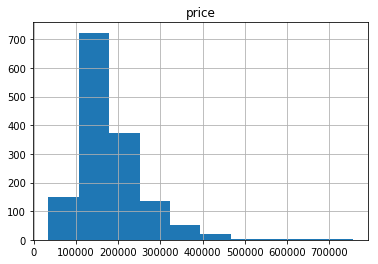

In [2]:
# check SalePrice的分布
%matplotlib inline
prices = pd.DataFrame({"price":df_train["SalePrice"]})
prices.hist()
    # 可看出不符合高斯分佈, 在下方用log1p平滑化

"\n產生以下dataframe：\ntrain_Y: 平滑化後的'SalePrice'\nids: ID of df_test\ndf: 合併df_train和df_test\n\n"

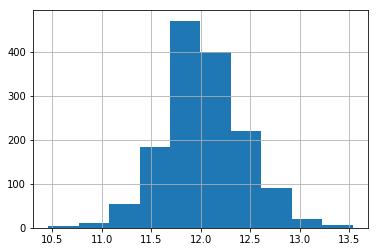

In [3]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
%matplotlib inline
train_Y = np.log1p(df_train['SalePrice'])
    # 對'SalePrice'欄位做平滑化，使其符合高斯分布
train_Y.hist()
    # check平滑後的分布圖

ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train,df_test])
    # 合併2個dataframe, axis= 0 default, 為垂直合併(欄位相同，資料往下疊)
df.head()

'''
產生以下dataframe：
train_Y: 平滑化後的'SalePrice'
ids: ID of df_test
df: 合併df_train和df_test

'''

In [5]:
print(type(df.dtypes))
df.dtypes
    # series

<class 'pandas.core.series.Series'>


MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


In [36]:
# 秀出資料欄位的類型, 與對應的數量
# df.dtypes : 轉成以欄位為 index, 類別(type)為 value 的 DataFrame
# .reset_index() : 預設是將原本的 index 轉成一個新的欄位, 如果不須保留 index, 則通常會寫成 .reset_index(drop=True)
dtype_df = df.dtypes.reset_index()
    # Reset the index, or a level of it.
dtype_df.columns = ["Count", "Column Type"]
    # 把index和0改為"Count", "Column Type"
dtype_df = dtype_df.groupby("Column Type").aggregate('count').reset_index()
    # 以column type來分組，此時的index為column type, 即[int64,float64,object],
    # 以aggregate找出各組的數量後，用reset_index()把index改為數字。
dtype_df

,Column Type,Count
0,int64,25
1,float64,11
2,object,43


In [37]:
# 確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於三個 list 中
int_features = []
float_features = []
object_features = []
# .dtypes(欄位類型), .columns(欄位名稱) 是 DataFrame 提供的兩個方法, 這裡順便展示一下 for 與 zip 搭配的用法
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)
# 這邊採用的寫法稱為 f-string, 是 Python 3.6.2 以後版本才出現的
# 如果無法執行, 則需要更新到這個版本之後, 或自行將程式改寫為 str.format 形式
# 改寫方式可以參考 https://blog.louie.lu/2017/08/08/outdate-python-string-format-and-fstring/
print(f'{len(int_features)} Integer Features : {int_features}\n')
print(f'{len(float_features)} Float Features : {float_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

25 Integer Features : ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

11 Float Features : ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

43 Object Features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Fi

In [38]:
#這樣就可以單獨秀出特定類型的欄位集合, 方便做後續的特徵工程處理
df[float_features].head()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
0,65.0,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2003.0,2.0,548.0
1,80.0,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,1976.0,2.0,460.0
2,68.0,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2001.0,2.0,608.0
3,60.0,0.0,216.0,0.0,540.0,756.0,1.0,0.0,1998.0,3.0,642.0
4,84.0,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,2000.0,3.0,836.0


# 作業1 
* 試著執行作業程式，觀察三種類型的欄位分別進行( 平均 mean / 最大值 Max / 相異值 nunique ) 中的九次操作會有那些問題?  
並試著解釋那些發生Error的程式區塊的原因?  

# 作業2
* 思考一下，試著舉出今天五種類型以外的一種或多種資料類型，你舉出的新類型是否可以歸在三大類中的某些大類?  
所以三大類特徵中，哪一大類處理起來應該最複雜?

## DataFrame.reset_index()
    Reset the index, or a level of it.

    Reset the index of the DataFrame, and use the default one instead. If the DataFrame has a MultiIndex, this method can remove one or more levels.

In [9]:
df_test = pd.DataFrame([('bird', 389.0),
                   ('bird', 24.0),
                   ('mammal', 80.5),
                   ('mammal', np.nan)],
                  index=['falcon', 'parrot', 'lion', 'monkey'],
                  columns=('class', 'max_speed'))
df_test

,class,max_speed
falcon,bird,389.0
parrot,bird,24.0
lion,mammal,80.5
monkey,mammal,NaN


In [11]:
# reset_index()
# When we reset the index, the old index is added as a column, and a new sequential index is used.
df_test.reset_index()

,index,class,max_speed
0,falcon,bird,389.0
1,parrot,bird,24.0
2,lion,mammal,80.5
3,monkey,mammal,NaN


In [12]:
# drop=True, 把原本index那欄刪了
# We can use the drop parameter to avoid the old index being added as a column.
df_test.reset_index(drop=True)


,class,max_speed
0,bird,389.0
1,bird,24.0
2,mammal,80.5
3,mammal,NaN


# pandas.DataFrame.groupby()
    。Group DataFrame using a mapper or by a Series of columns
    。Returns a groupby object that contains information about the groups.

In [7]:
df_test = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df_test

,Animal,Max Speed
0,Falcon,380.0
1,Falcon,370.0
2,Parrot,24.0
3,Parrot,26.0


In [11]:
x=df_test.groupby(['Animal'])
type(x)
    # return a groupby object

pandas.core.groupby.groupby.DataFrameGroupBy

In [19]:
print(dir(x))
    # groupby object可用的properties

['Animal', '__bytes__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__unicode__', '__weakref__', '_accessors', '_add_numeric_operations', '_agg_doc', '_aggregate', '_aggregate_generic', '_aggregate_item_by_item', '_aggregate_multiple_funcs', '_apply_filter', '_apply_to_column_groupbys', '_apply_whitelist', '_assure_grouper', '_block_agg_axis', '_bool_agg', '_builtin_table', '_choose_path', '_concat_objects', '_constructor', '_cumcount_array', '_cython_agg_blocks', '_cython_agg_general', '_cython_table', '_cython_transform', '_decide_output_index', '_def_str', '_define_paths', '_deprecations', '_dir_additions', '_dir_deletions', '_fill', '_get_cythonized

In [21]:
print(x.mean())
print(x.max())
print(x.min())

        Max Speed
Animal           
Falcon      375.0
Parrot       25.0
        Max Speed
Animal           
Falcon      380.0
Parrot       26.0
        Max Speed
Animal           
Falcon      370.0
Parrot       24.0


In [22]:
x.aggregate([min,np.median,max])
    # Aggregate using one or more operations over the specified axis.
    # 此例可看到，依animal分組，並用aggregate做聚合計算min, median, max

Max Speed              
             min median    max
Animal                        
Falcon     370.0  375.0  380.0
Parrot      24.0   25.0   26.0

In [27]:
# aggregate的另一例

rng=np.random.RandomState(0)
df_test2=pd.DataFrame({'key':['a','b','c','a','b','c'],
                      'data1':range(6),
                      'data2':rng.randint(0,10,6)},
                     columns=['key','data1','data2'])
df_test2

,key,data1,data2
0,a,0,5
1,b,1,0
2,c,2,3
3,a,3,3
4,b,4,7
5,c,5,9


In [28]:
df_test2.groupby('key').aggregate({'data1':min,'data2':max})
    # 依key欄位分組，data1那欄找min，data2欄找max
    # 以字典型式, key為欄位，value為計算

,data1,data2
key,,
a,0,5
b,1,7
c,2,9


In [30]:
df_test2.groupby('key').aggregate({'data1':[min,np.median],'data2':max})
    # 'data1':[op1,op2,...]的型式。

data1        data2
      min median   max
key                   
a       0    1.5     5
b       1    2.5     7
c       2    3.5     9

In [31]:
df_test2.groupby('key').aggregate('count')
    # 統計各分組內的數量

,data1,data2
key,,
a,2,2
b,2,2
c,2,2
